In [1]:
# Essential Libraries
import os
import sys
import numpy as np
import pandas as pd
import datetime
import random

# ML
from sklearn import datasets
import keras
import tensorflow as tf


# Plots
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
sns.set_style("whitegrid");
sns.set_color_codes(palette='pastel');

# Display options
pd.set_option('display.max_columns', None);
pd.options.display.max_seq_items = 8000;
pd.options.display.max_rows = 8000;
%precision 6

# Ignore Warnings
import warnings
warnings.filterwarnings(action="ignore")

# Define data and image directory
PROJECT_ROOT_DIR = "."
DATA_DIR = os.path.join(PROJECT_ROOT_DIR, "data")
IMAGE_DIR = os.path.join(PROJECT_ROOT_DIR, "img")

from IPython.display import Image
for d in [DATA_DIR, IMAGE_DIR]:
    if not os.path.exists(d):
        os.mkdir(d)

# Define a function to save images
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGE_DIR, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
from pprint import pprint

# This is a little recursive helper function converts all nested ndarrays to python list of lists so that pretty printer knows what to do.

def arrayToList(arr):
    if type(arr) == type(np.array):
        #If the passed type is an ndarray then convert it to a list and
        #recursively convert all nested types
        return arrayToList(arr.tolist())
    else:
        #if item isn't an ndarray leave it as is.
        return arr
    
# Suppress exponential notation, define an appropriate float formatter
# Specify stdout line width and let pretty print do the work
np.set_printoptions(suppress=True, formatter={'float_kind':'{:12.6f}'.format}, linewidth=120)

In [2]:
X, y = datasets.make_classification(n_samples=10000, n_features=5, n_classes=4, 
                                    n_clusters_per_class=1, shuffle=True, random_state=1)
print(f'X type: {type(X)}, X shape: {X.shape}, X dimention: {X.ndim}')
print(f'y type: {type(y)}, y shape: {y.shape}, y dimention: {y.ndim}')

X type: <class 'numpy.ndarray'>, X shape: (10000, 5), X dimention: 2
y type: <class 'numpy.ndarray'>, y shape: (10000,), y dimention: 1


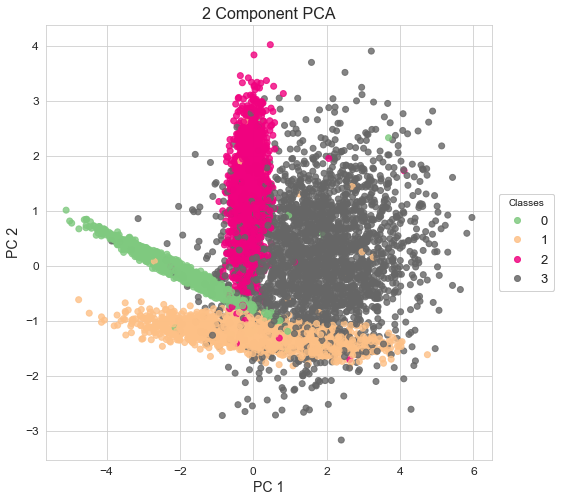

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_components=2))])

X_pca = pipeline.fit_transform(X)
y = y.astype(int)

df = pd.DataFrame(np.column_stack((X_pca, y)), columns = ['PC 1', 'PC 2', 'target']).astype({"target": int})


fig, ax = plt.subplots(figsize = (8, 8))
scatter = ax.scatter(df['PC 1'], df['PC 2'], c=df.target, alpha=0.8, cmap='Accent')
legend = ax.legend(*scatter.legend_elements(), loc='center left', 
                   bbox_to_anchor=(1, 0.5), fontsize = 13, title="Classes")
ax.add_artist(legend)
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_title('2 Component PCA', fontsize = 16)
plt.show()

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

def relu(x):
    return (x >= 0) * x # returns x if x > 0
                        # returns 0 otherwise

def relu2deriv(output):
    return output >= 0 #returns 1 for input > 0

def onehot(arr):
    one_hot_labels = np.zeros((len(arr),4))
    for i,l in enumerate(arr):
        one_hot_labels[i][l] = 1
        
    return one_hot_labels

y_train = onehot(y_train)
y_test = onehot(y_test)

alpha, iterations, hidden_size = (0.002, 300, 10)

weights_0_1 = 0.2*np.random.random((5, hidden_size)) - 0.1
weights_1_2 = 0.2*np.random.random((hidden_size, 4)) - 0.1

train_err_lst, train_acc_lst, test_err_lst, test_acc_lst = [], [], [], []

for j in range(iterations):
    error, correct_cnt = (0.0,0)
    for i in range(len(X_train)):
        layer_0 = X_train[i:i+1]
        layer_1 = relu(np.dot(layer_0,weights_0_1))
        dropout_mask = np.random.randint(2, size=layer_1.shape)
        layer_1 *= dropout_mask * 2
        layer_2 = np.dot(layer_1,weights_1_2)

        error += np.sum((y_train[i:i+1] - layer_2) ** 2)
        correct_cnt += int(np.argmax(layer_2) == np.argmax(y_train[i:i+1]))
        layer_2_delta = (y_train[i:i+1] - layer_2)
        layer_1_delta = layer_2_delta.dot(weights_1_2.T) * relu2deriv(layer_1)
        layer_1_delta *= dropout_mask

        weights_1_2 += alpha * layer_1.T.dot(layer_2_delta)
        weights_0_1 += alpha * layer_0.T.dot(layer_1_delta)

    if(j%1 == 0):
        test_error = 0.0
        test_correct_cnt = 0

        for i in range(len(X_test)):
            layer_0 = X_test[i:i+1]
            layer_1 = relu(np.dot(layer_0, weights_0_1))
            layer_2 = np.dot(layer_1, weights_1_2)

            test_error += np.sum((y_test[i:i+1] - layer_2) ** 2)
            test_correct_cnt += int(np.argmax(layer_2) == np.argmax(y_test[i:i+1]))

        train_err_lst.append(error/ float(len(X_train)))
        train_acc_lst.append(correct_cnt/ float(len(X_train)))
        test_err_lst.append(test_error/ float(len(X_test)))
        test_acc_lst.append(test_correct_cnt/ float(len(X_test)))
        
        sys.stdout.write("\n" + \
                     "I:" + str(j) + \
                     " Test-Err:" + str(test_error/ float(len(X_test)))[0:5] +\
                     " Test-Acc:" + str(test_correct_cnt/ float(len(X_test)))+\
                     " Train-Err:" + str(error/ float(len(X_train)))[0:5] +\
                     " Train-Acc:" + str(correct_cnt/ float(len(X_train))))        


I:0 Test-Err:0.465 Test-Acc:0.795 Train-Err:0.696 Train-Acc:0.58775
I:1 Test-Err:0.451 Test-Acc:0.8 Train-Err:0.576 Train-Acc:0.646875
I:2 Test-Err:0.450 Test-Acc:0.801 Train-Err:0.574 Train-Acc:0.648
I:3 Test-Err:0.450 Test-Acc:0.8065 Train-Err:0.577 Train-Acc:0.651125
I:4 Test-Err:0.454 Test-Acc:0.808 Train-Err:0.578 Train-Acc:0.65225
I:5 Test-Err:0.447 Test-Acc:0.8085 Train-Err:0.568 Train-Acc:0.66925
I:6 Test-Err:0.445 Test-Acc:0.8055 Train-Err:0.565 Train-Acc:0.668875
I:7 Test-Err:0.445 Test-Acc:0.803 Train-Err:0.573 Train-Acc:0.661625
I:8 Test-Err:0.447 Test-Acc:0.81 Train-Err:0.576 Train-Acc:0.659375
I:9 Test-Err:0.442 Test-Acc:0.813 Train-Err:0.569 Train-Acc:0.670125
I:10 Test-Err:0.453 Test-Acc:0.8115 Train-Err:0.578 Train-Acc:0.65025
I:11 Test-Err:0.452 Test-Acc:0.8035 Train-Err:0.573 Train-Acc:0.6565
I:12 Test-Err:0.464 Test-Acc:0.807 Train-Err:0.575 Train-Acc:0.64825
I:13 Test-Err:0.454 Test-Acc:0.812 Train-Err:0.578 Train-Acc:0.6515
I:14 Test-Err:0.454 Test-Acc:0.803 Trai

KeyboardInterrupt: 

In [ ]:
df = pd.DataFrame(list(zip(train_err_lst, train_acc_lst, test_err_lst, test_acc_lst)), 
                  columns=['train_error', 'train_acc', 'test_error', 'test_acc'])

fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (15, 6))
df[['train_error', 'test_error']].plot(ax = axes[0], title = 'Train vs Test Error')
df[['train_acc', 'test_acc']].plot(ax = axes[1], title = 'Train vs Test Accruacy')
axes[0].set_xlabel("Iteration")
axes[0].set_ylabel("Error")
axes[0].set_xticklabels(df.index*5)
axes[0].title.set_size(16)
axes[1].set_xlabel("Iteration")
axes[1].set_ylabel("Accuracy")
axes[1].set_xticklabels(df.index*5)
axes[1].title.set_size(16)
plt.show()

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

def relu(x):
    return (x >= 0) * x # returns x if x > 0
                        # returns 0 otherwise

def relu2deriv(output):
    return output >= 0 #returns 1 for input > 0

def onehot(arr):
    one_hot_labels = np.zeros((len(arr),4))
    for i,l in enumerate(arr):
        one_hot_labels[i][l] = 1
        
    return one_hot_labels

y_train = onehot(y_train)
y_test = onehot(y_test)

alpha, iterations, hidden_size = (0.002, 300, 10)

weights_0_1 = 0.2*np.random.random((5, hidden_size)) - 0.1
weights_1_2 = 0.2*np.random.random((hidden_size, 4)) - 0.1
b = np.zeros(10).reshape(1, 10)

train_err_lst, train_acc_lst, test_err_lst, test_acc_lst = [], [], [], []

for j in range(iterations):
    error, correct_cnt = (0.0,0)
    for i in range(len(X_train)):
        layer_0 = X_train[i:i+1]
        layer_1 = relu(np.dot(layer_0,weights_0_1) + b)
        dropout_mask = np.random.randint(2, size=layer_1.shape)
        layer_1 *= dropout_mask * 2
        layer_2 = np.dot(layer_1,weights_1_2)

        error += np.sum((y_train[i:i+1] - layer_2) ** 2)
        correct_cnt += int(np.argmax(layer_2) == np.argmax(y_train[i:i+1]))
        layer_2_delta = (y_train[i:i+1] - layer_2)
        layer_1_delta = layer_2_delta.dot(weights_1_2.T) * relu2deriv(layer_1)
        layer_1_delta *= dropout_mask
        b_delta = np.sum(layer_1_delta, axis = 0)

        weights_1_2 += alpha * layer_1.T.dot(layer_2_delta)
        weights_0_1 += alpha * layer_0.T.dot(layer_1_delta)
        b += -alpha*b_delta

    if(j%1 == 0):
        test_error = 0.0
        test_correct_cnt = 0

        for i in range(len(X_test)):
            layer_0 = X_test[i:i+1]
            layer_1 = relu(np.dot(layer_0, weights_0_1))
            layer_2 = np.dot(layer_1, weights_1_2)

            test_error += np.sum((y_test[i:i+1] - layer_2) ** 2)
            test_correct_cnt += int(np.argmax(layer_2) == np.argmax(y_test[i:i+1]))

        train_err_lst.append(error/ float(len(X_train)))
        train_acc_lst.append(correct_cnt/ float(len(X_train)))
        test_err_lst.append(test_error/ float(len(X_test)))
        test_acc_lst.append(test_correct_cnt/ float(len(X_test)))
        
        sys.stdout.write("\n" + \
                     "I:" + str(j) + \
                     " Test-Err:" + str(test_error/ float(len(X_test)))[0:5] +\
                     " Test-Acc:" + str(test_correct_cnt/ float(len(X_test)))+\
                     " Train-Err:" + str(error/ float(len(X_train)))[0:5] +\
                     " Train-Acc:" + str(correct_cnt/ float(len(X_train)))) 


I:0 Test-Err:0.471 Test-Acc:0.8 Train-Err:0.780 Train-Acc:0.541625
I:1 Test-Err:0.476 Test-Acc:0.808 Train-Err:0.668 Train-Acc:0.631375
I:2 Test-Err:0.465 Test-Acc:0.8105 Train-Err:0.674 Train-Acc:0.65175
I:3 Test-Err:0.497 Test-Acc:0.8165 Train-Err:0.682 Train-Acc:0.645625
I:4 Test-Err:0.482 Test-Acc:0.8145 Train-Err:0.703 Train-Acc:0.6375
I:5 Test-Err:0.610 Test-Acc:0.803 Train-Err:0.701 Train-Acc:0.634375
I:6 Test-Err:0.591 Test-Acc:0.794 Train-Err:0.709 Train-Acc:0.63725
I:7 Test-Err:0.700 Test-Acc:0.797 Train-Err:0.703 Train-Acc:0.6095
I:8 Test-Err:0.622 Test-Acc:0.782 Train-Err:0.697 Train-Acc:0.595875
I:9 Test-Err:0.640 Test-Acc:0.7795 Train-Err:0.698 Train-Acc:0.605625
I:10 Test-Err:0.780 Test-Acc:0.7575 Train-Err:0.704 Train-Acc:0.591625
I:11 Test-Err:0.788 Test-Acc:0.76 Train-Err:0.705 Train-Acc:0.597625
I:12 Test-Err:0.913 Test-Acc:0.744 Train-Err:0.703 Train-Acc:0.6105
I:13 Test-Err:0.920 Test-Acc:0.738 Train-Err:0.708 Train-Acc:0.636375
I:14 Test-Err:1.031 Test-Acc:0.712 

I:117 Test-Err:3.027 Test-Acc:0.711 Train-Err:0.827 Train-Acc:0.545625
I:118 Test-Err:2.574 Test-Acc:0.6335 Train-Err:0.822 Train-Acc:0.543625
I:119 Test-Err:2.913 Test-Acc:0.623 Train-Err:0.818 Train-Acc:0.5495
I:120 Test-Err:2.580 Test-Acc:0.5885 Train-Err:0.828 Train-Acc:0.551875
I:121 Test-Err:4.089 Test-Acc:0.62 Train-Err:0.817 Train-Acc:0.56425
I:122 Test-Err:2.988 Test-Acc:0.527 Train-Err:0.809 Train-Acc:0.575375
I:123 Test-Err:3.063 Test-Acc:0.63 Train-Err:0.832 Train-Acc:0.5785
I:124 Test-Err:2.938 Test-Acc:0.6595 Train-Err:0.830 Train-Acc:0.580375
I:125 Test-Err:3.503 Test-Acc:0.6045 Train-Err:0.855 Train-Acc:0.571125
I:126 Test-Err:2.975 Test-Acc:0.539 Train-Err:0.831 Train-Acc:0.574375
I:127 Test-Err:2.449 Test-Acc:0.6655 Train-Err:0.823 Train-Acc:0.579125
I:128 Test-Err:3.397 Test-Acc:0.644 Train-Err:0.849 Train-Acc:0.5705
I:129 Test-Err:3.594 Test-Acc:0.586 Train-Err:0.828 Train-Acc:0.5765
I:130 Test-Err:3.173 Test-Acc:0.643 Train-Err:0.876 Train-Acc:0.565
I:131 Test-Err:

I:232 Test-Err:4.073 Test-Acc:0.552 Train-Err:0.903 Train-Acc:0.498875
I:233 Test-Err:3.000 Test-Acc:0.516 Train-Err:0.974 Train-Acc:0.489125
I:234 Test-Err:5.681 Test-Acc:0.569 Train-Err:0.909 Train-Acc:0.51275
I:235 Test-Err:4.853 Test-Acc:0.576 Train-Err:0.895 Train-Acc:0.5065
I:236 Test-Err:4.941 Test-Acc:0.5575 Train-Err:0.920 Train-Acc:0.508125
I:237 Test-Err:5.030 Test-Acc:0.4715 Train-Err:0.907 Train-Acc:0.5025
I:238 Test-Err:4.622 Test-Acc:0.5855 Train-Err:0.900 Train-Acc:0.49625
I:239 Test-Err:4.641 Test-Acc:0.5825 Train-Err:0.965 Train-Acc:0.4925
I:240 Test-Err:6.151 Test-Acc:0.4705 Train-Err:0.952 Train-Acc:0.47725
I:241 Test-Err:5.125 Test-Acc:0.599 Train-Err:0.928 Train-Acc:0.483375
I:242 Test-Err:5.621 Test-Acc:0.597 Train-Err:0.975 Train-Acc:0.478375
I:243 Test-Err:5.397 Test-Acc:0.637 Train-Err:0.905 Train-Acc:0.485625
I:244 Test-Err:4.058 Test-Acc:0.565 Train-Err:0.893 Train-Acc:0.49775
I:245 Test-Err:5.939 Test-Acc:0.6105 Train-Err:0.942 Train-Acc:0.48375
I:246 Test-